# Conversion from ROOT gtrac to plain text csv file using the library uproot

Loading the ROOT files and preprocessing to create one file containing both siganl and background with longitudal, transverse, and total momentum, angle between muon and neutrino, angle between muon and proton, and total energy of proton and muon. Deleting every instance of more and less than 2 particles, and removing the data that doesn't meet the minimum total momentum for each particle needed to be registered and the data where the angle between particles is not within range of reconstruction.

In [1]:
import uproot
import pandas as pd
import awkward as ak
import numpy as np
import time
start_time = time.time()

# PID codes for neutral particles that may appear as end products: regarded as undetectable for DUNE
neutral_particles = [-12, 12, -14, 14, -16, 16, -2112, 2112, -111, 111, -3122, 3122, -3212, 3212,
                        -421, 421, -311, 311, -130, 130, 2000000101, 1000180400, 130, 310, 3322, -3322, 221, 331, 443]


# Calculating angle between two particles
def angle(df, vec1_cols, vec2_cols):
   
    x1, y1, z1 = vec1_cols
    x2, y2, z2 = vec2_cols
    

    dot_product = (df[x1] * df[x2] + df[y1] * df[y2] + df[z1] * df[z2])

    mag_A = np.sqrt(df[x1]**2 + df[y1]**2 + df[z1]**2)
    mag_B = np.sqrt(df[x2]**2 + df[y2]**2 + df[z2]**2)
    
    cosine_angle = np.clip(dot_product / (mag_A * mag_B), -1.0, 1.0)
    angle_rad = np.arccos(cosine_angle)
    
    return angle_rad


def extract_data(filename):
    
    file = uproot.open(filename)
    tree = file["gRooTracker"]


    

    stdhep_status=tree["StdHepStatus"].array()

    stdhep_status_df=ak.to_dataframe(stdhep_status)
    del stdhep_status

    stdhep_status_df =stdhep_status_df.reset_index()
    stdhep_status_df.rename(columns={"values": "status"}, inplace=True)
    stdhep_Pdg=tree["StdHepPdg"].array()

    stdhep_Pdg_df=ak.to_dataframe(stdhep_Pdg)

    del stdhep_Pdg
    stdhep_Pdg_df =stdhep_Pdg_df.reset_index()

    stdhep_Pdg_df.rename(columns={"values": "Pdg"}, inplace=True)



    stdhep_merge=stdhep_Pdg_df[["Pdg"]].join(stdhep_status_df[["status"]])


    del stdhep_Pdg_df
    del stdhep_status_df

    branches = [
        "EvtNum"
    ]

    stdhep_p4 = tree["StdHepP4"].array()
    
    #Split up each mommomentum components in
    stdhep_p4_rec = ak.zip({
        
        "px": stdhep_p4[..., 0],
        "py": stdhep_p4[..., 1],
        "pz": stdhep_p4[..., 2],
        "E":  stdhep_p4[..., 3],
    })

    del stdhep_p4
    stdhep_df = ak.to_dataframe(stdhep_p4_rec)
    del stdhep_p4_rec

    df = tree.arrays(branches, library="pd")


    proc_split=ak.to_dataframe(tree['EvtCode/fString'].array())['values']
    proc_split=proc_split.reset_index() 
    proc_split.rename(columns={"entry": "EvtNum","values": "EvtCode"}, inplace=True)
    
    stdhep_df = stdhep_df.reset_index() 
    stdhep_df.rename(columns={"entry": "EvtNum", "subentry": "particle"}, inplace=True)
    stdhep_df=stdhep_df.drop('particle',axis=1)
    
    merged = pd.merge(stdhep_df,df, on="EvtNum")
    
    del stdhep_df
    del df
    merged = pd.merge(merged,proc_split, on="EvtNum")
    proc_split
    total_merged=merged.join(stdhep_merge)
    
    del merged
    total_merged=total_merged[total_merged["status"] == 1]
    total_merged=total_merged[~total_merged["Pdg"].isin(neutral_particles)]
    
    total_merged=total_merged.drop(['status','EvtCode'],axis=1)
    total_merged['row_number'] = total_merged.groupby('EvtNum').cumcount() + 1
   
    #Pivot the table to create separate columns
    df_wide = total_merged.pivot(index='EvtNum', columns='row_number')
    #introducing a mask to delete events with more than two particles generated
    
    mask= df_wide["px"][3].isnull()
    df_wide=df_wide[mask]
    
    

    
    #Flatten MultiIndex columns
    df_wide.columns = [f'{col}_{num}' for col, num in df_wide.columns]
    #drop empty columns (old columns that were in place for the events with more than two particles)
    df_wide=df_wide.dropna(axis='columns',how='all')
    
    #drop rows where there is one NaN (only one particle registered)
    df_wide=df_wide.dropna(axis='rows',how='any')
    

    #creating mask to swap particles indexed as 1 to 2 if the particle is a muon
    muonmask = df_wide['Pdg_1'] == 13
    
    #selecting rows where values need to be swapped and swapping particle 1 and particle 2
    df_wide.loc[muonmask, ['px_1', 'px_2','py_1','py_2','pz_1','pz_2','E_1','E_2','Pdg_1','Pdg_2']] = df_wide.loc[muonmask, ['px_2', 'px_1','py_2','py_1','pz_2','pz_1','E_2','E_1','Pdg_2','Pdg_1']].values
    #deleting rows where particle 1 is not a proton and particle 2 is not a muon
    muonmask2= (df_wide['Pdg_2'] == 13)
    muonclean= df_wide[muonmask2].copy()
    

    del df_wide
    #total momentum calculation
    muonclean.loc[:,'ptot_1']=np.sqrt(muonclean['px_1']**2+muonclean['py_1']**2+muonclean['pz_1']**2)
    muonclean.loc[:,'ptot_2']=np.sqrt(muonclean['px_2']**2+muonclean['py_2']**2+muonclean['pz_2']**2)
    #minimum momentums for muon, kaon, and pion >0.01 GeV
    muonminmask=muonclean['ptot_2']>0.01
    muonclean=muonclean[muonminmask]
    three_pdg_values = [-211, 211, 321, -321, 13]
    otherpaticlemask=((muonclean['Pdg_1'].isin(three_pdg_values)) & (muonclean['ptot_1']>0.01)) | (muonclean['ptot_1']>0.29)
    muonclean=muonclean[otherpaticlemask]
    #new dataframe with longitudal, transerve and total momentum, angle between muon and proton, angle between muon and neutrino, and total energy
     
    organizeddata=pd.DataFrame({'energy': muonclean['E_1'] + muonclean['E_2']})
    organizeddata['pt_p']=np.sqrt(muonclean['px_1']**2+muonclean['py_1']**2)
    organizeddata['pl_p']=muonclean['pz_1']
    organizeddata['ptot_p']=muonclean['ptot_1']
    organizeddata['pt_mu']=np.sqrt(muonclean['px_2']**2+muonclean['py_2']**2)
    organizeddata['pl_mu']=muonclean['pz_2']
    organizeddata['ptot_mu']=muonclean['ptot_2']
    organizeddata['alpha']=angle(muonclean, ['px_1','py_1','pz_1'],['px_2','py_2','pz_2'])
    
    #angle between muon and neutrino calculation
    muonclean['x']=0
    muonclean['y']=0
    muonclean['z']=1
    organizeddata['theta']=angle(muonclean, ['x','y','z'],['px_2','py_2','pz_2'])
    del muonclean
    #sort out angles that are 0.3 < alpha < 2.8 in radians
    anglemask=(organizeddata['alpha']< 2.8) &(organizeddata['alpha'] > 0.3) 
    organizeddata=organizeddata[anglemask]
    organizeddata=organizeddata.reset_index()
    organizeddata=organizeddata.drop("EvtNum",axis=1)
    return organizeddata
    """
    #Reset index
    df_wide = df_wide.reset_index()
    
    df_wide=sort_columns_by_suffix(df_wide)

    df_total = pd.merge(proc_split,df_wide, on="EvtNum")
    del proc_split,df_wide
    df_total.fillna(0, inplace=True)
    
    df_total.to_csv(exportname, index=False)
    """

#combining the tau and mu data, labeling signal and background and exporting into one file
def exportdata(tau,mu,exportname):
    tau.insert(loc=0, column='y', value=1)
    mu.insert(loc=0, column='y', value=0)
    mergeddata=pd.concat([tau, mu], ignore_index=True)
    del tau,mu
    mergeddata.to_csv(exportname, index=False)
    del mergeddata
    return 0


#extracting from gtrac
tau=extract_data('gntp.0.gtrac_tau_1mil.root')
mu=extract_data('gntp.0.gtrac_mu_1mil.root')



#Combining the signal and background into one file
exportdata(tau,mu,'trainingdata.csv')
print("--- %s seconds ---" % (time.time() - start_time))






--- 54.57457184791565 seconds ---


Extraction but without the minimum momentums and the restricted angles.

In [2]:
def extract_data(filename):
    
    file = uproot.open(filename)
    tree = file["gRooTracker"]


    

    stdhep_status=tree["StdHepStatus"].array()

    stdhep_status_df=ak.to_dataframe(stdhep_status)
    del stdhep_status

    stdhep_status_df =stdhep_status_df.reset_index()
    stdhep_status_df.rename(columns={"values": "status"}, inplace=True)
    stdhep_Pdg=tree["StdHepPdg"].array()

    stdhep_Pdg_df=ak.to_dataframe(stdhep_Pdg)

    del stdhep_Pdg
    stdhep_Pdg_df =stdhep_Pdg_df.reset_index()

    stdhep_Pdg_df.rename(columns={"values": "Pdg"}, inplace=True)



    stdhep_merge=stdhep_Pdg_df[["Pdg"]].join(stdhep_status_df[["status"]])


    del stdhep_Pdg_df
    del stdhep_status_df

    branches = [
        "EvtNum"
    ]

    stdhep_p4 = tree["StdHepP4"].array()
    
    #Split up each mommomentum components in
    stdhep_p4_rec = ak.zip({
        
        "px": stdhep_p4[..., 0],
        "py": stdhep_p4[..., 1],
        "pz": stdhep_p4[..., 2],
        "E":  stdhep_p4[..., 3],
    })

    del stdhep_p4
    stdhep_df = ak.to_dataframe(stdhep_p4_rec)
    del stdhep_p4_rec

    df = tree.arrays(branches, library="pd")


    proc_split=ak.to_dataframe(tree['EvtCode/fString'].array())['values']
    proc_split=proc_split.reset_index() 
    proc_split.rename(columns={"entry": "EvtNum","values": "EvtCode"}, inplace=True)
    
    stdhep_df = stdhep_df.reset_index() 
    stdhep_df.rename(columns={"entry": "EvtNum", "subentry": "particle"}, inplace=True)
    stdhep_df=stdhep_df.drop('particle',axis=1)
    
    merged = pd.merge(stdhep_df,df, on="EvtNum")
    
    del stdhep_df
    del df
    merged = pd.merge(merged,proc_split, on="EvtNum")
    proc_split
    total_merged=merged.join(stdhep_merge)
    
    del merged
    total_merged=total_merged[total_merged["status"] == 1]
    total_merged=total_merged[~total_merged["Pdg"].isin(neutral_particles)]
    
    total_merged=total_merged.drop(['status','EvtCode'],axis=1)
    total_merged['row_number'] = total_merged.groupby('EvtNum').cumcount() + 1
    #Pivot the table to create separate columns
    df_wide = total_merged.pivot(index='EvtNum', columns='row_number')
    #introducing a mask to delete events with more than two particles generated
    
    mask= df_wide["px"][3].isnull()
    df_wide=df_wide[mask]
    
    

    
    #Flatten MultiIndex columns
    df_wide.columns = [f'{col}_{num}' for col, num in df_wide.columns]
    #drop empty columns (old columns that were in place for the events with more than two particles)
    df_wide=df_wide.dropna(axis='columns',how='all')
    
    #drop rows where there is one NaN (only one particle registered)
    df_wide=df_wide.dropna(axis='rows',how='any')
    

    #creating mask to swap particles indexed as 1 to 2 if the particle is a muon
    muonmask = df_wide['Pdg_1'] == 13
    
    #selecting rows where values need to be swapped and swapping particle 1 and particle 2
    df_wide.loc[muonmask, ['px_1', 'px_2','py_1','py_2','pz_1','pz_2','E_1','E_2','Pdg_1','Pdg_2']] = df_wide.loc[muonmask, ['px_2', 'px_1','py_2','py_1','pz_2','pz_1','E_2','E_1','Pdg_2','Pdg_1']].values
    #deleting rows where particle 1 is not a proton and particle 2 is not a muon
    muonmask2= (df_wide['Pdg_2'] == 13)
    muonclean= df_wide[muonmask2].copy()
    

    del df_wide
    #total momentum calculation
    muonclean.loc[:,'ptot_1']=np.sqrt(muonclean['px_1']**2+muonclean['py_1']**2+muonclean['pz_1']**2)
    muonclean.loc[:,'ptot_2']=np.sqrt(muonclean['px_2']**2+muonclean['py_2']**2+muonclean['pz_2']**2)
    
    #new dataframe with longitudal, transerve and total momentum, angle between muon and proton, angle between muon and neutrino, and total energy
    organizeddata=pd.DataFrame({'energy': muonclean['E_1'] + muonclean['E_2']})
    organizeddata['pt_p']=np.sqrt(muonclean['px_1']**2+muonclean['py_1']**2)
    organizeddata['pl_p']=muonclean['pz_1']
    organizeddata['ptot_p']=muonclean['ptot_1']
    organizeddata['pt_mu']=np.sqrt(muonclean['px_2']**2+muonclean['py_2']**2)
    organizeddata['pl_mu']=muonclean['pz_2']
    organizeddata['ptot_mu']=muonclean['ptot_2']
    organizeddata['alpha']=np.degrees(angle(muonclean, ['px_1','py_1','pz_1'],['px_2','py_2','pz_2']))
    
    #angle between muon and neutrino calculation
    muonclean['x']=0
    muonclean['y']=0
    muonclean['z']=1
    organizeddata['theta']=np.degrees(angle(muonclean, ['x','y','z'],['px_2','py_2','pz_2']))
    del muonclean
    
    organizeddata=organizeddata.reset_index()
    organizeddata=organizeddata.drop("EvtNum",axis=1)
    return organizeddata


tau=extract_data('gntp.0.gtrac_tau_1mil.root')
mu=extract_data('gntp.0.gtrac_mu_1mil.root')














Visualization of the various parameter distributions:

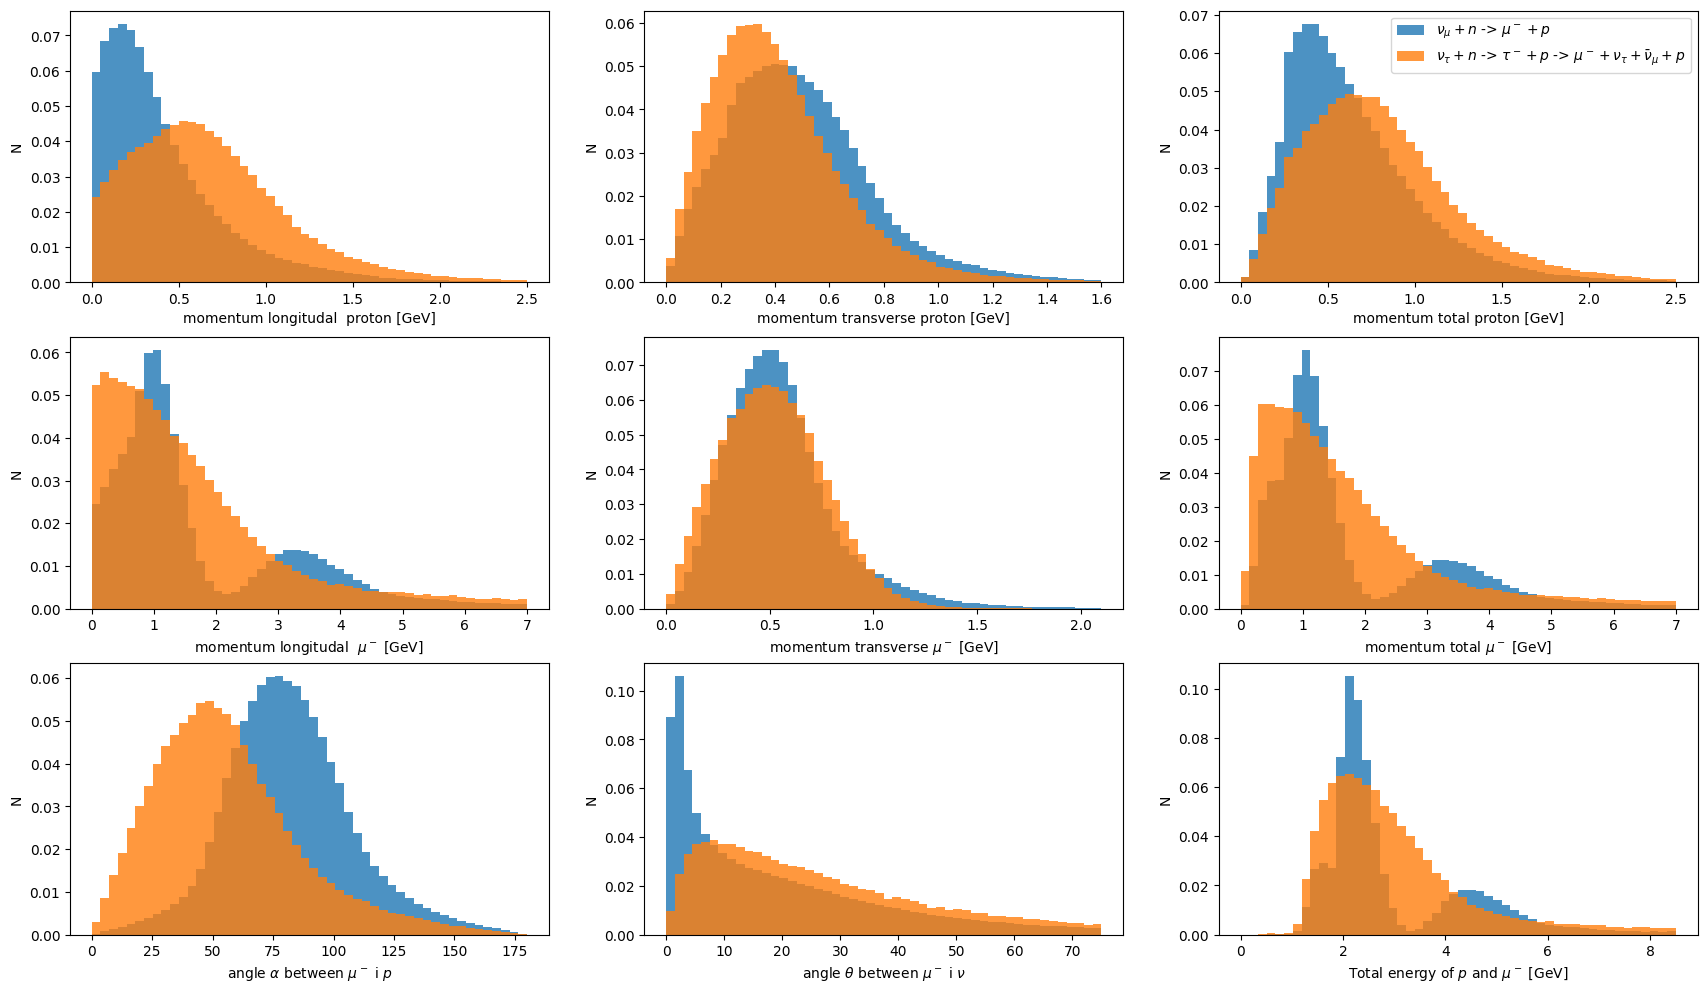

In [4]:
import matplotlib.pyplot as plt 



parameter_dict = {'pl_p': ['pl_p', 'momentum longitudal  proton [GeV]', (0, 2.5)], 
                  'pt_p': ['pt_p', 'momentum transverse proton [GeV]', (0, 1.6)], 
                  'ptot_p': ['ptot_p', 'momentum total proton [GeV]', (0, 2.5)], 
                  'pl_mu': ['pl_mu', r'momentum longitudal  $\mu^-$ [GeV]', (0, 7)], 
                  'pt_mu': ['pt_mu', r'momentum transverse $\mu^-$ [GeV]', (0, 2.1)], 
                  'ptot_mu': ['ptot_mu', r'momentum total $\mu^-$ [GeV]', (0, 7)],  
                  'alpha': ['alpha', r'angle $\alpha$ between $\mu^-$ i $p$', (0, 180)], 
                  'theta': ['theta', r'angle $\theta$ between $\mu^-$ i $\nu$', (0, 75)], 
                  'energy': ['energy', r'Total energy of $p$ and $\mu^-$ [GeV]', (0, 8.5)]}

def histograms(mu_data, tau_data, parameter, parameter_dict, axs):
    idx, x_label, hist_range = parameter_dict[list(parameter_dict.keys())[parameter]]
    
    mu, edges = np.histogram(mu_data[idx], bins = 50, range = hist_range)
    tau = np.histogram(tau_data[idx], bins = 50, range = hist_range)[0]
    mu_hist = [mu[i] / len(mu_data) for i in range(len(mu))]
    tau_hist = [tau[i] / len(tau_data) for i in range(len(tau))]
    w = edges[2] - edges[1]
    centers = [(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]
    axs[parameter%3].bar(centers, mu_hist, width = w, alpha = 0.8, label=r'$\nu_\mu + n$ -> $\mu^- + p$')
    axs[parameter%3].bar(centers, tau_hist, width = w, alpha = 0.8, linewidth = 1, 
                         label=r'$\nu_\tau + n$ -> $\tau^- + p$ -> $\mu^- + \nu_\tau + \bar\nu_\mu + p$')
    axs[parameter%3].set_xlabel(x_label)
    axs[parameter%3].set_ylabel('N')
    if parameter == 2:
        axs[parameter%3].legend()
fig, [axs1, axs2, axs3] = plt.subplots(3, 3, figsize=(21, 12))
for i in range(0, 3): 
    histograms(mu, tau, i, parameter_dict, axs1)
for i in range(3, 6): 
    histograms(mu, tau,  i, parameter_dict, axs2)
for i in range(6, 9): 
    histograms(mu, tau,  i, parameter_dict, axs3)
plt.show()